In [1]:
import torch
import matplotlib.pyplot as plt

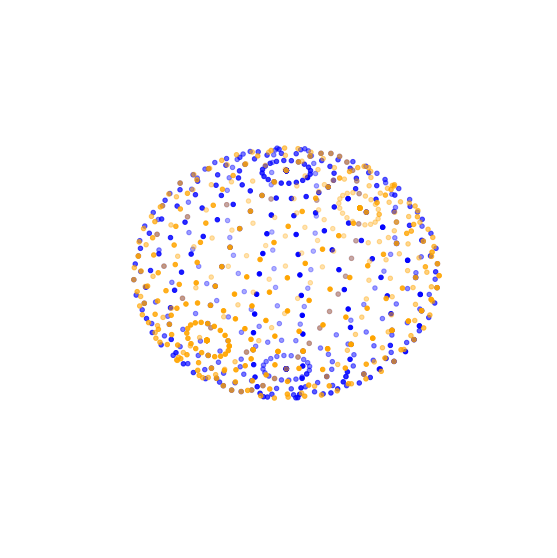

In [ ]:
n_angle = 20
theta = torch.pi*torch.arange(n_angle+1) / n_angle
phi = 2*theta



X = torch.tensordot(torch.sin(theta), torch.cos(phi), dims=0)
Y = torch.tensordot(torch.sin(theta), torch.sin(phi), dims=0)
Z = torch.cos(theta).unsqueeze(-1).repeat(1,n_angle+1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_size_inches(10,10)
#ax.scatter(X, Y, Z, c='blue', s=20)
ax.scatter(X, Z, Y, c='orange', s=20)
ax.scatter(X, Y, Z, c='blue', s=20)

ax.set_axis_off()
plt.show()

/home/riki/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/home/riki/anaconda3/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


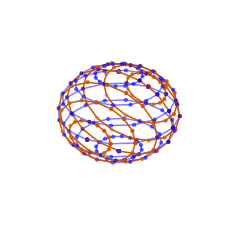

In [101]:
import matplotlib.pyplot as plt
import numpy as np

n_angle = 16
theta = 2*torch.pi*torch.arange(n_angle//2+1) / n_angle
phi = 2*torch.pi*torch.arange(n_angle+1) / n_angle

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# # Line 1
# for j in range(len(theta)):
#     ax.scatter3D(torch.cos(phi)*torch.sin(theta[j]), torch.sin(phi)*torch.sin(theta[j]), torch.cos(theta[j]), c='r', s=5)
#     ax.plot3D(torch.cos(phi)*torch.sin(theta[j]), torch.sin(phi)*torch.sin(theta[j]), torch.cos(theta[j]), 'r-')
    
    
X = torch.tensordot(torch.sin(theta), torch.cos(phi), dims=0)
Y = torch.tensordot(torch.sin(theta), torch.sin(phi), dims=0)
Z = torch.cos(theta).unsqueeze(-1).repeat(1,n_angle+1)

# Line 1
for j in range(len(theta)):
    ax.scatter3D(X[j], Y[j], Z[j], c='blue', s=10, alpha=0.5)
    ax.plot3D(X[j], Y[j], Z[j], 'blue', alpha=0.5)


# Line 1
for j in range(len(theta)):
    ax.scatter3D(X[j], Z[j], Y[j], c='#CC5500', s=10)
    ax.plot3D(X[j], Z[j], Y[j], '#CC5500')

ax.set_axis_off()
plt.show()